# Compute Opinion Distances 

R. C. Alvarado | <rca2t@virginia.edu> | 2021-09-18

We compute distances between majority and dissenting opinions per case where both exist (i.e. using the compressed corpus created previously). We compute distance in different spaces using different measures.

# Set Up

## Imports

In [1]:
import pandas as pd
import numpy as np
from lib.helper import Db, lmplot

# import sqlite3
# import sqlalchemy as sqa

import scipy.stats as stats
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

import plotly_express as px

In [2]:
import seaborn as sns

In [3]:
sns.set()

## Config

In [4]:
base_path = ''
db_file = f'{base_path}db/ussc.db'
OHCO = ['vol_num','case_num','position']

# Import Tables

## Connect to database

This database contains all the data from previous notebooks.

In [5]:
db = Db(db_file)

In [6]:
db.list_tables_in_db()

['AUTHOR',
 'BOW',
 'CASE',
 'CORPUS',
 'CORPUS_COMPRESSED',
 'D2V',
 'D2VP',
 'DCM',
 'PHI',
 'PHI_NMF',
 'THETA',
 'THETA_NMF',
 'TOPICS',
 'TOPICS_NMF',
 'VOCAB',
 'YEAR']

## Import tables and define indexes

In [7]:
db.import_table('CASE', OHCO[:2])
db.import_table('THETA', OHCO)
db.import_table('YEAR', 'year')
db.import_table('D2V', OHCO)

In [8]:
db.import_table('DCM', OHCO)

In [9]:
# db.DCM.head()

# Compute Distances

## Define combos of vector space and distance metric

In [10]:
spaces = ['THETA', 'DCM']
dists  = ['cityblock', 'cosine', 'jensenshannon']
combos = {s: {d: f"dist_{s.lower()}_{d}" for d in dists} for s in spaces}
combo_cols = [combos[s][d] for s in combos for d in combos[s]]
combo_mean_cols = [col+'_mean' for col in combo_cols]

We apply the distance metric in each space to the `opinion` and `dissent` pair of vectors for each case returned by the `groupby()` method.

## Compute distances

In [11]:
for s in combos.keys():
    df = getattr(db, s)
    for d in combos[s].keys():
        col = combos[s][d]
        db.CASE[col] = df.groupby(OHCO[:2]).apply(lambda x: pdist(x, d)[0])

## Aggregate by Year

In [12]:
db.YEAR['case_count']    = db.CASE.groupby('year').year.count()
db.YEAR['doc_len_sum']   = db.CASE.groupby('year').doc_len_sum.sum()
db.YEAR['doc_len_mean']  = db.CASE.groupby('year').doc_len_sum.mean()

In [13]:
agg_cols = [col+'_mean' for col in combo_cols]
for col, agg_col in zip(combo_cols, agg_cols):
    db.YEAR[agg_col] = db.CASE.groupby('year').agg({col:'mean'})

In [14]:
# db.YEAR 

In [15]:
Y = db.YEAR.reset_index()

In [16]:
Y.head()

,year,doc_len_sum,doc_len_mean,opinion_count,case_count,dist_theta_cityblock_mean,dist_theta_cosine_mean,dist_theta_jensenshannon_mean,dist_dcm_cityblock_mean,dist_dcm_cosine_mean,dist_dcm_jensenshannon_mean
0,1789,38585,19292.500000,3,2,0.608257,0.085771,0.359950,0.461142,0.115142,inf
1,1794,7740,3870.000000,2,2,NaN,NaN,NaN,NaN,NaN,NaN
2,1795,10487,5243.500000,2,2,NaN,NaN,NaN,NaN,NaN,NaN
3,1796,51193,10238.600000,10,5,1.499677,0.653835,0.674967,1.168001,0.894948,inf
4,1797,21407,7135.666667,4,3,NaN,NaN,NaN,NaN,NaN,NaN


## Add Ration Features

In [17]:
Y['r_cases_over_doc_len_mean'] = (Y.case_count / Y.doc_len_mean)
Y['r_cases_over_doc_len_sum'] = (Y.case_count / Y.doc_len_sum)
Y['r_opinion_per_case'] = Y.opinion_count / Y.case_count

## Clip at 1900

In [18]:
Y19 = Y[Y.year >= 1900]

## Define Col Groups

In [19]:
dist_cols = [col for col in Y.columns if 'dist_theta' in col]
theta_cols = [col for col in Y.columns if 'theta' in col]
dcm_cols = [col for col in Y.columns if 'dcm' in col]
vol_cols = [col for col in Y.columns if 'dist_' not in col and 'r_' not in col and col != 'year']
ratio_cols = [col for col in Y.columns if 'r_' in col]

# Volume $V$ over Time

## Ratios

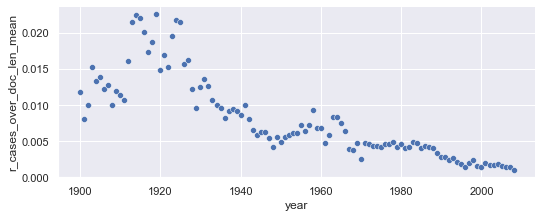

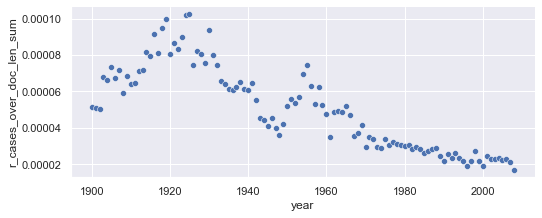

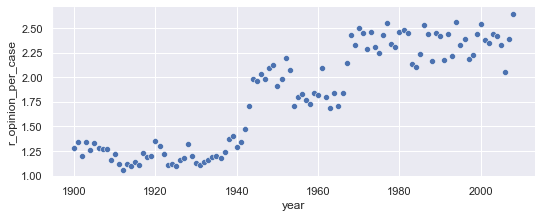

In [77]:
for col in ratio_cols:
    sns.relplot(data=Y19, x='year', y=col, height=3, aspect=2.5)

## Scalars

In [103]:
# px.scatter(Y19, 'year', 'case_count', size='doc_len_mean', color='doc_len_sum', height=600)

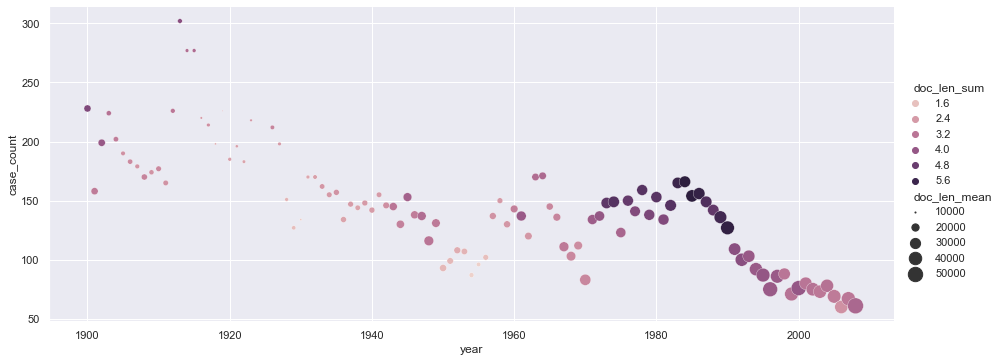

In [104]:
sns.relplot(data=Y19, x='year', y='case_count', size='doc_len_mean', sizes=(0,250), hue='doc_len_sum', aspect=2.5);

In [97]:
# px.scatter(Y19, 'year', 'doc_len_sum', size='case_count', color='doc_len_mean', height=600)

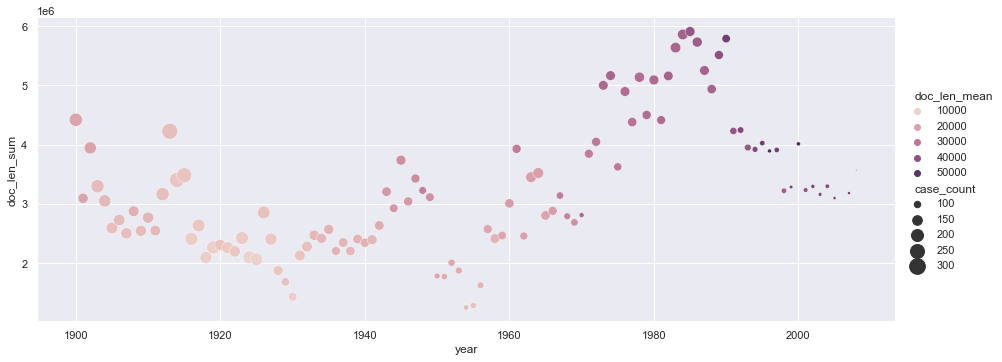

In [98]:
sns.relplot(data=Y19, x='year', y='doc_len_sum', size='case_count', sizes=(0,250), hue='doc_len_mean', aspect=2.5);

In [99]:
# px.scatter(Y19, 'year', 'doc_len_mean', size='case_count', color='doc_len_sum', height=600)

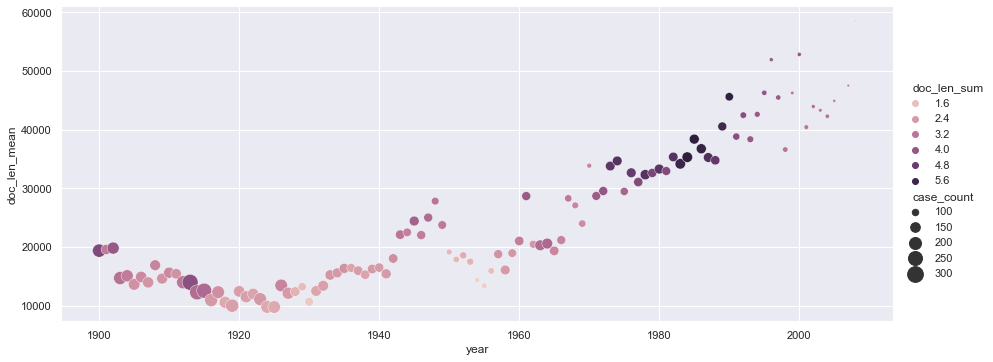

In [100]:
sns.relplot(data=Y19, x='year', y='doc_len_mean', size='case_count', sizes=(0,250), hue='doc_len_sum', aspect=2.5);

In [101]:
# px.scatter(Y19, 'doc_len_sum', 'doc_len_mean', size='case_count', color='year', height=600)

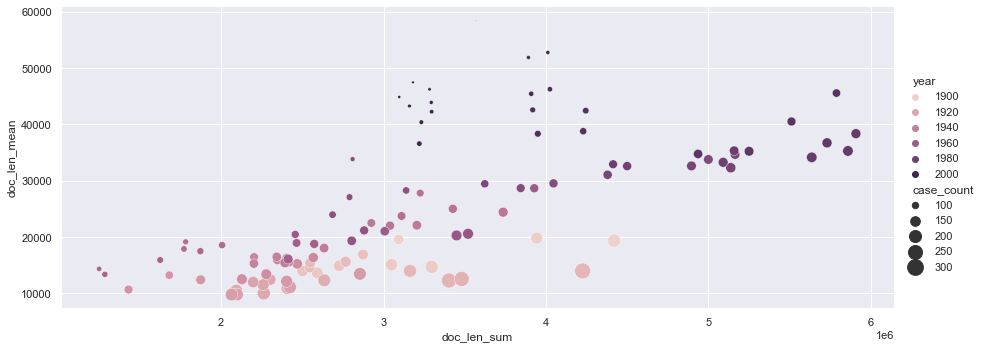

In [102]:
sns.relplot(data=Y19, x='doc_len_sum', y='doc_len_mean', size='case_count', sizes=(0,250), hue='year', aspect=2.5);

# Distance $D$ over Time

In [49]:
C19 = db.CASE[db.CASE.year >= 1900].reset_index()

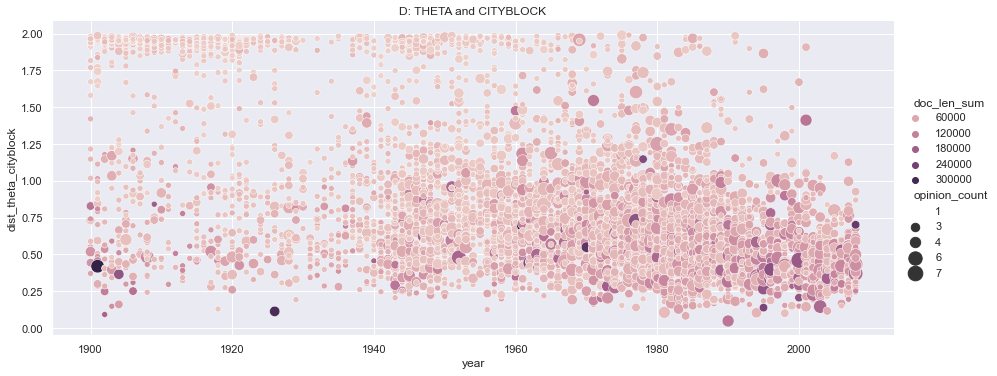

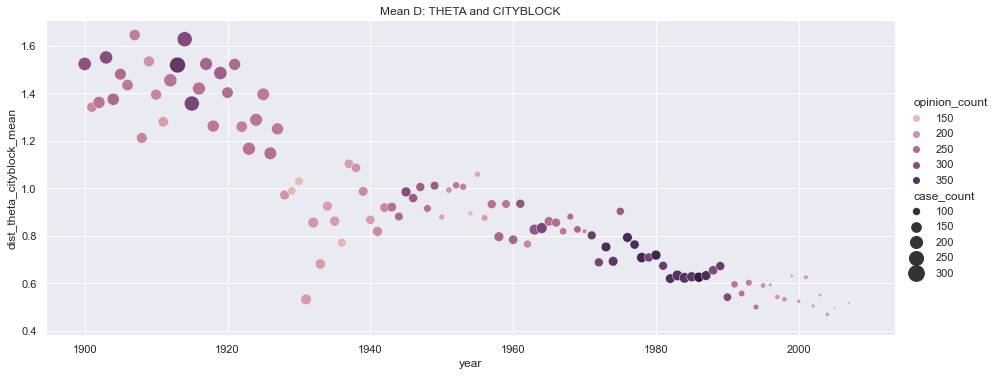

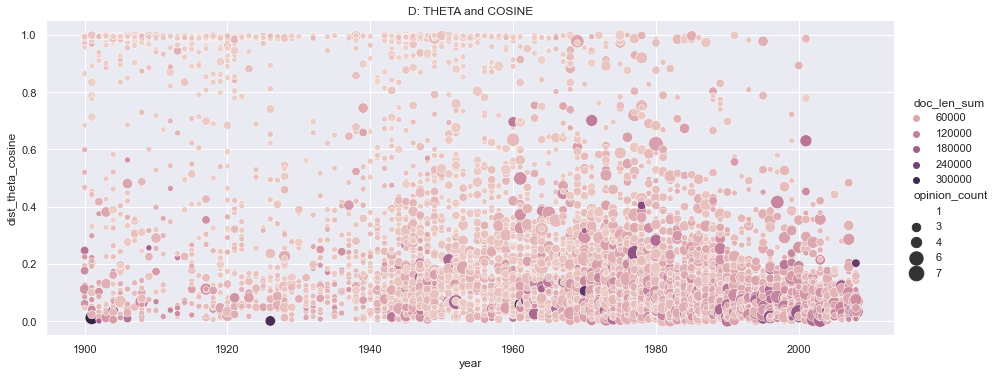

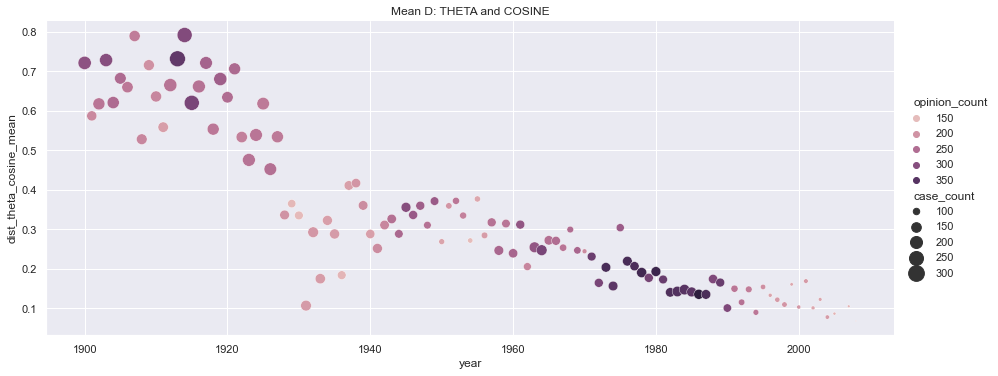

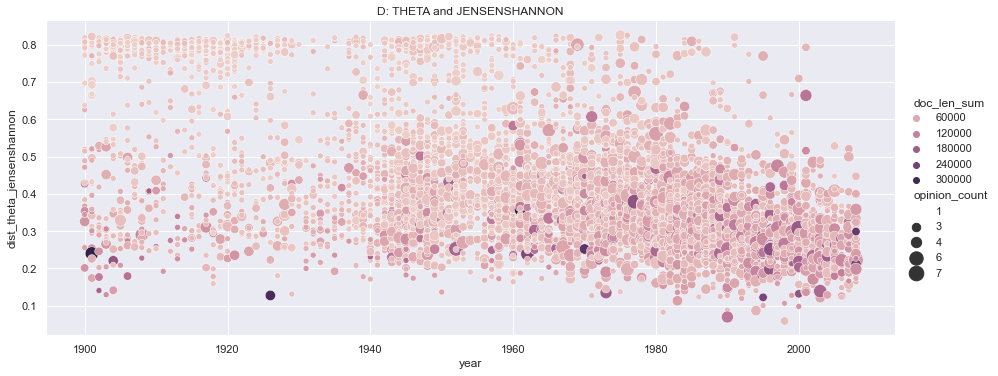

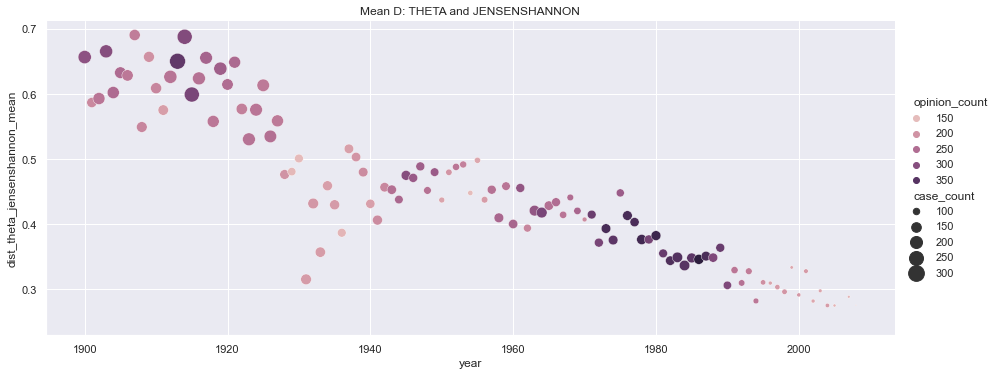

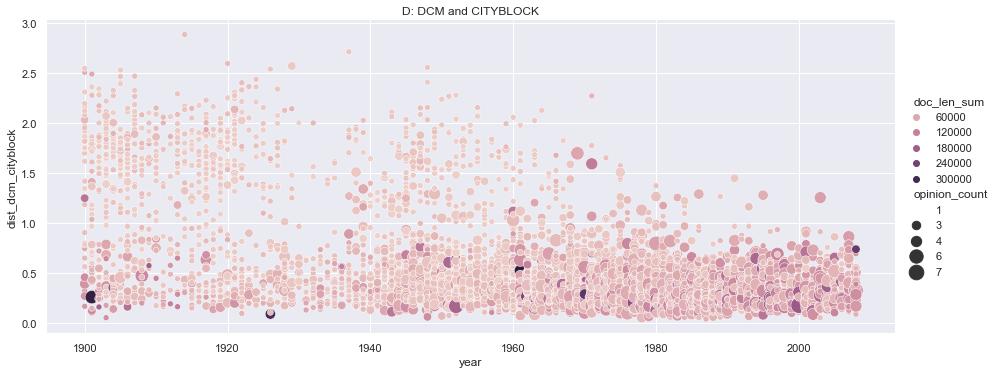

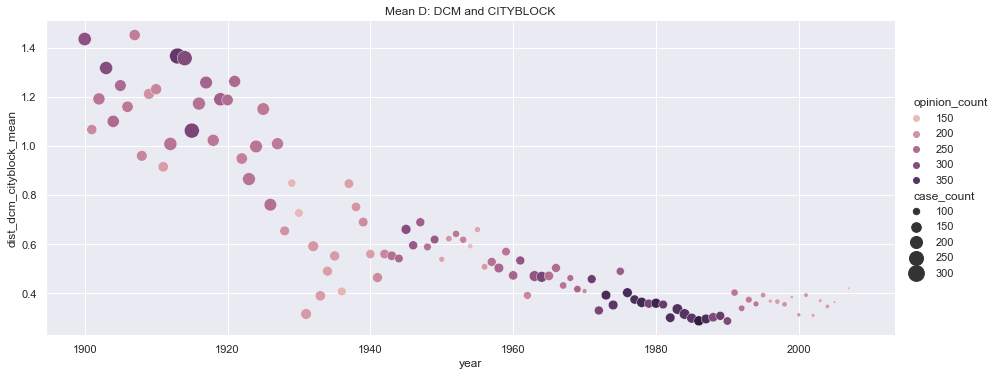

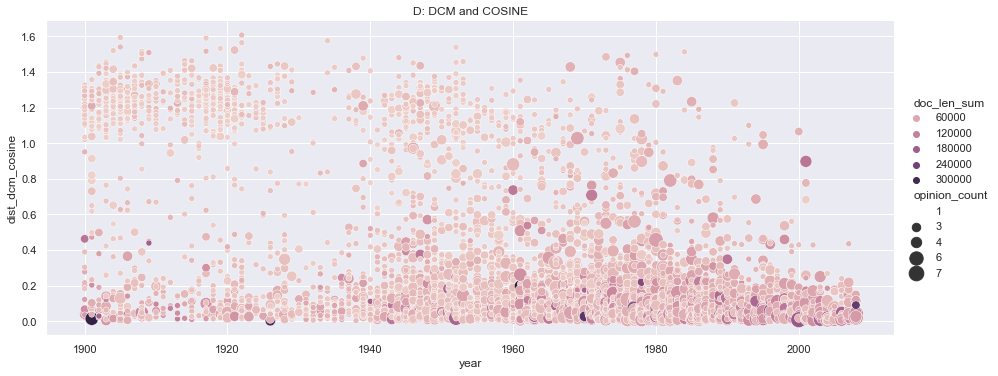

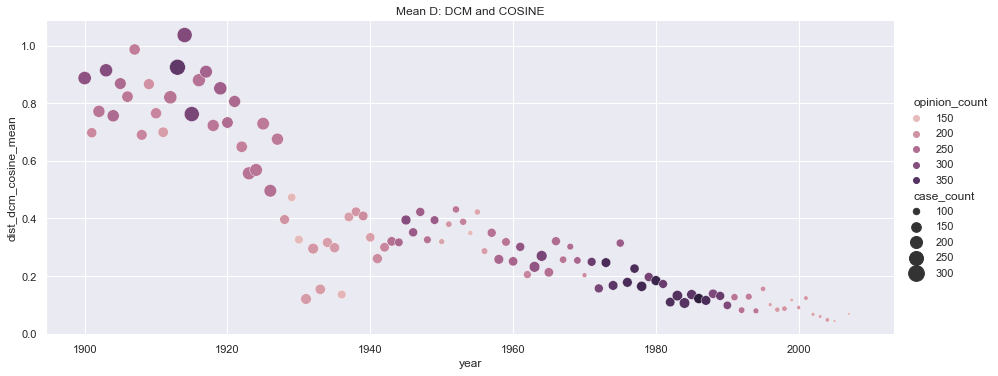

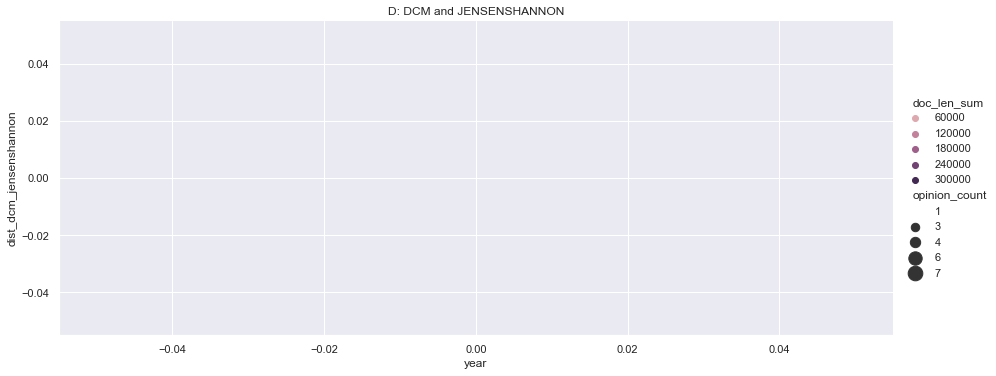

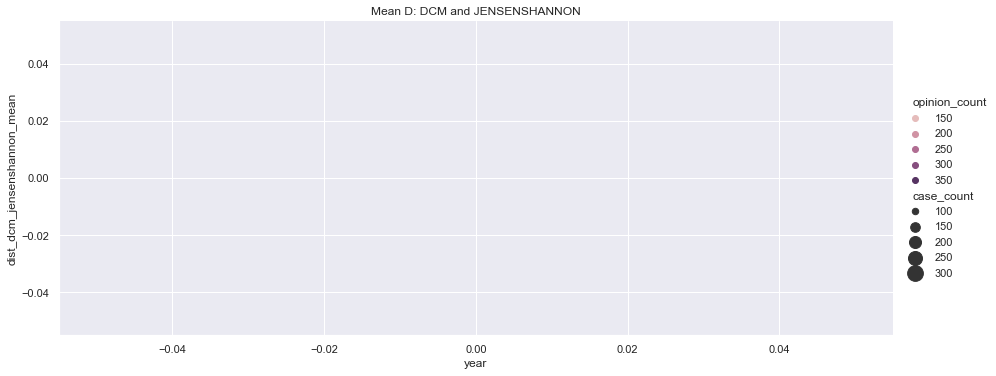

In [107]:
for s in combos.keys():
    df = getattr(db, s)
    for d in combos[s].keys():
        col = combos[s][d]

        title = ' and '.join(col.upper().split('_')[1:])
        title = 'D: ' + title
        
        # Individual cases over time
        sns.relplot(data=C19, x='year', y=col, size='opinion_count', sizes=(0,250), hue='doc_len_sum', aspect=2.5)\
            .set(title=title)
        
        # Aggregate case stats over time
        sns.relplot(data=Y19, x='year', y=col+"_mean", size='case_count', sizes=(0,250), hue='opinion_count', aspect=2.5)\
            .set(title='Mean '+title)

In [72]:
# for s in combos.keys():
#     df = getattr(db, s)
#     for d in combos[s].keys():
#         col = combos[s][d]
#         title = ' by '.join(col.upper().split('_')[1:])
#         title = 'D = ' + title
#         # Individual cases over time
#         fig = px.scatter(C19, 'year', col, 
#                          size='doc_len_sum',
#                          color='opinion_count',                        
#                          hover_name='case_title',
#                          hover_data=['case_num','vol_num'], 
#                          height=600)
#         fig.update_layout(
#             title=title,
#             xaxis_title="Year",
#             yaxis_title=""
#         )
#         fig.show()
#         # Aggregate case stats over time
#         fig = px.scatter(Y19, 'year', col+'_mean', 
#                          height=600, 
#                          size='case_count', 
#                          color='opinion_count')
#         fig.update_layout(
#             title="Mean " + title,
#             xaxis_title="Year",
#             yaxis_title=""
#         )
#         fig.show()

# Regressions

In [26]:
P = lmplot(Y19).set_x('year').set_order(2)

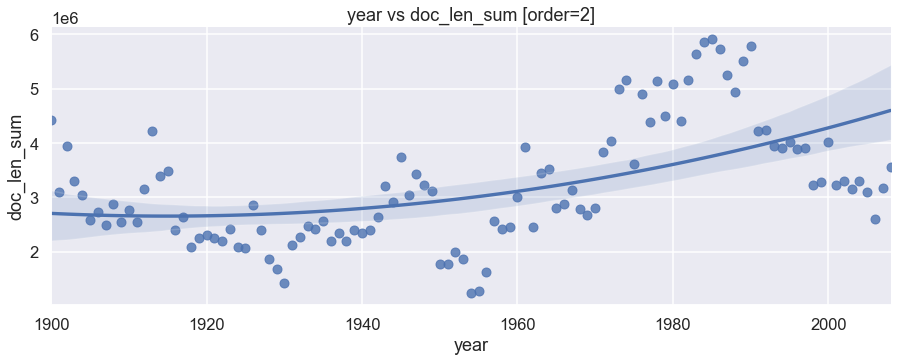

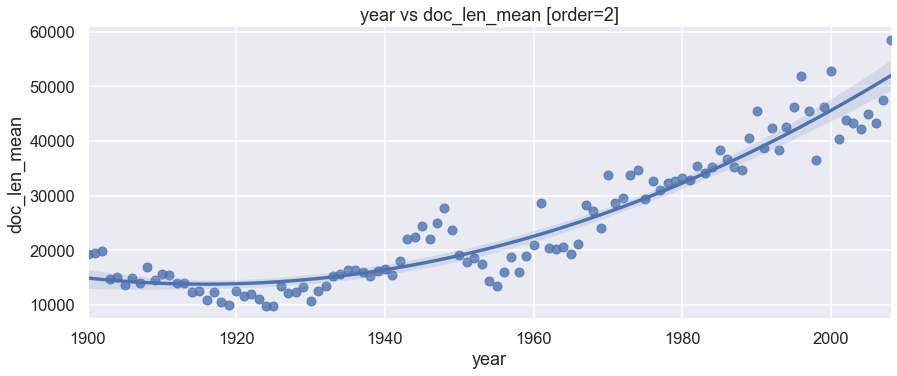

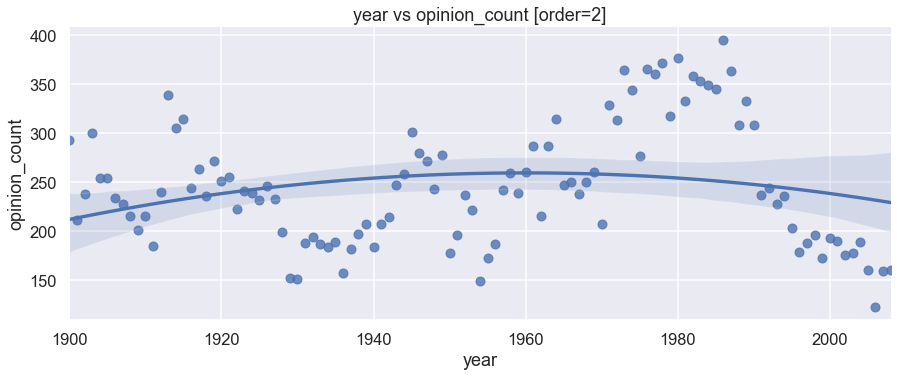

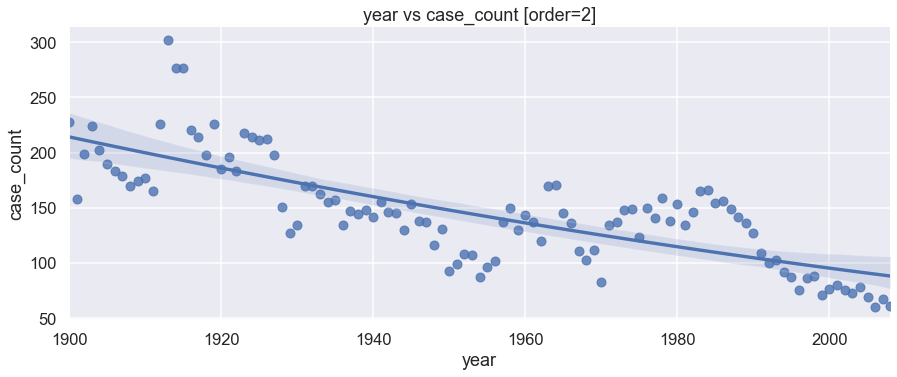

In [27]:
for col in vol_cols:
    P.set_y(col).plot()

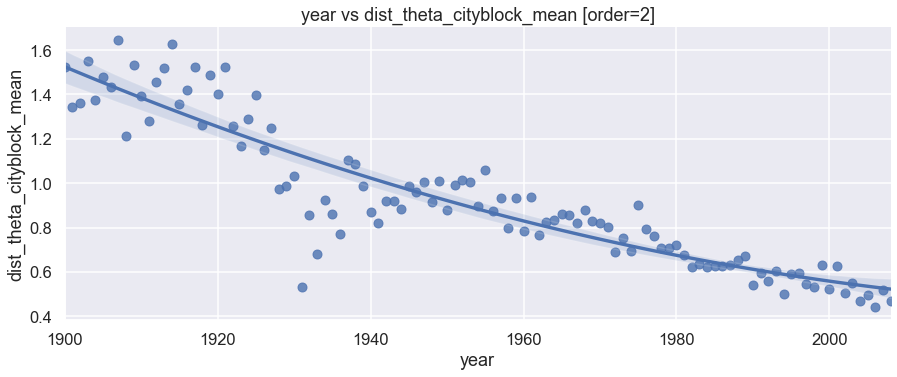

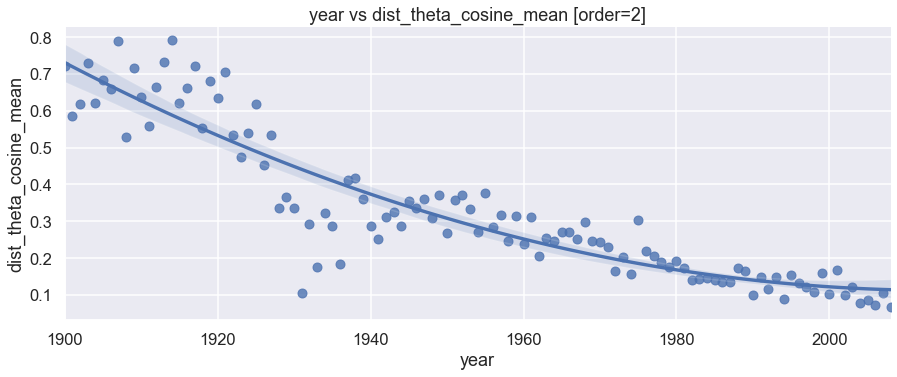

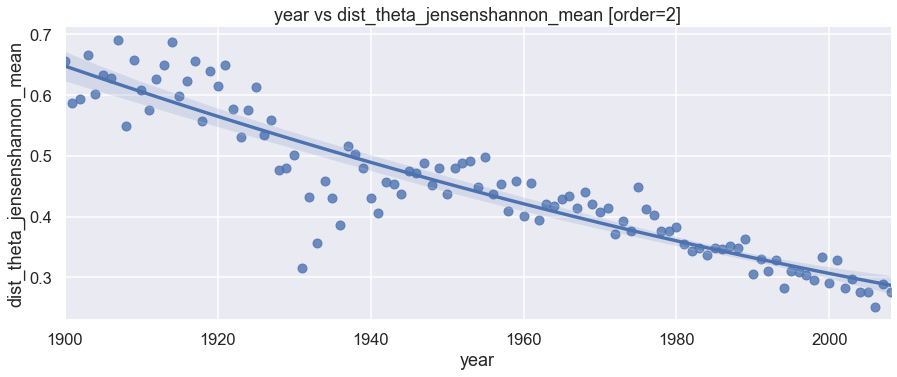

In [28]:
for col in dist_cols:
    P.set_order(2)
    P.set_y(col).plot()

# Correlate $V$ and $D$

## Pick Representative Features from $D$ and $V$

In [29]:
v = 'doc_len_mean'
d = 'dist_theta_cosine_mean'

## RelPlot

In [30]:
Z = Y19.set_index('year')
Z = (Z - Z.mean()) / Z.std() # Normalize
# sns.relplot(data=Z, kind='line', height=10, aspect=2.5);

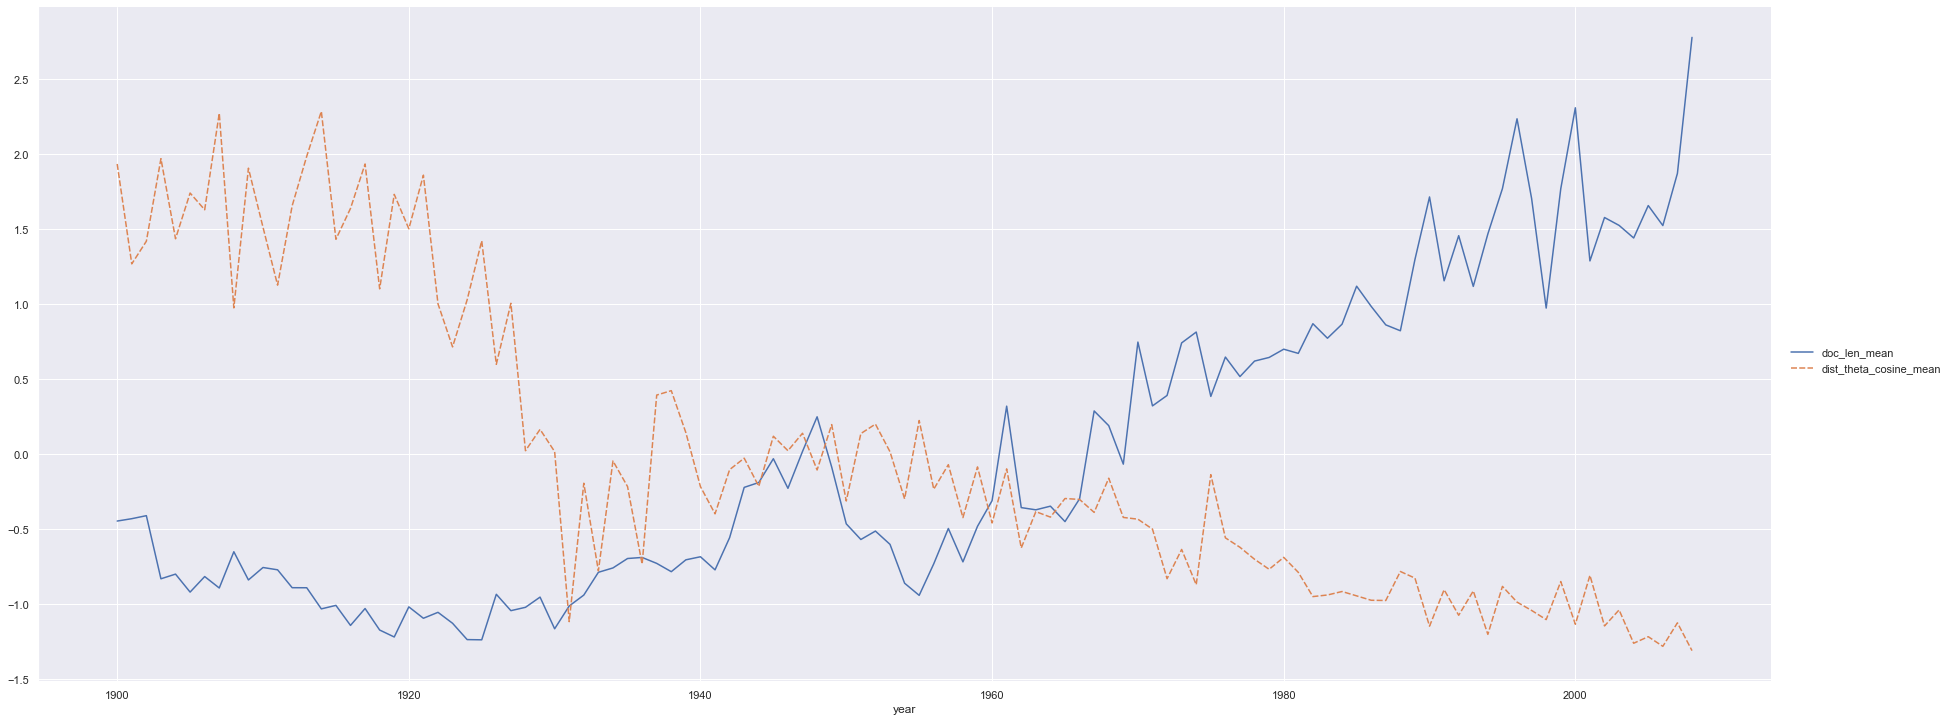

In [31]:
sns.relplot(data=Z[[v,d]], kind='line', height=10, aspect=2.5);

## Simple Correlation

* pearson : standard correlation coeff* icient
* kendall : Kendall Tau correlation coefficient
* spearman : Spearman rank correlation

In [32]:
methods = ['pearson','kendall','spearman']
corrs = []
for method in methods:
    c = round(Y19[[d,v]].corr(method=method).values[1][0], 2)
    corrs.append((method,c))
C = pd.DataFrame(corrs, columns=['method','result'])

In [33]:
C

,method,result
0,pearson,-0.75
1,kendall,-0.65
2,spearman,-0.83


In [34]:
round(C.result.mean(), 2)

-0.74

A perfect negative correlation has a value of -1.0 and indicates that when X increases by z units, Y decreases by exactly z; and vice-versa. In general, -1.0 to -0.70 suggests a strong negative correlation, -0.50 a moderate negative relationship, and -0.30 a weak correlation.

## T-Tests

In [35]:
stats.ttest_rel(Y19[d], Y19[v]).pvalue

1.5717268689314533e-40

In [36]:
stats.ttest_ind(Y19[d], Y19[v],  equal_var=False).pvalue

1.5700241568569195e-40

The smaller the p-value, the stronger the evidence that you should reject the null hypothesis.
A p-value less than 0.05 (typically ≤ 0.05) is statistically significant. ...
A p-value higher than 0.05 (> 0.05) is not statistically significant and indicates strong evidence for the null hypothesis.